**Ficheux et al, arXiv:2011.02634**

In this notebook we want to capture the basic effect behind the two-qubit gate for fluxonia described in the paper by Ficheux et al(2020) "Fast logic with slow qubits:microwave-activated controlled-Z gate on low-frequency fuxoniums"

In [2]:
import numpy as np
import sys
import time
import qutip as qtp 
import cmath
import matplotlib.pyplot as plt
from scipy import constants
import pysqkit
from pysqkit.util.linalg import get_mat_elem, tensor_prod
from pysqkit.solvers import solvkit
from typing import List
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'

from itertools import product, combinations
from IPython.display import display, Latex

%matplotlib notebook
plt.rcParams['figure.figsize'] = (8, 5)

The gate is based on the following driven Hamiltonian of two-capacitively coupled fluxonium qubits

$$\hat{H} = \hat{H}^{(0)}_A + \hat{H}^{(0)}_B + \hat{V} + \hat{H}_{drive}$$

$$\hat{H}^{(0)}_A = 4 E_{C,A} \cdot \hat{n}^2_A + \frac{1}{2}E_{L,A}\cdot\hat{\varphi}^2_A - E_{J,A}\cos\left(\hat{\varphi}_A - \phi_{ext,A}\right)$$

$$\hat{H}^{(0)}_B = 4 E_{C,B} \cdot \hat{n}^2_B + \frac{1}{2}E_{L,B}\cdot\hat{\varphi}^2_B - E_{J,B}\cos\left(\hat{\varphi}_B - \phi_{ext,B}\right)$$

$$\hat{V} = J_C \cdot \hat{n}_A \cdot \hat{n}_B$$

$$\frac{\hat{H}_{drive}}{h} = \left( \epsilon_A \hat{n}_A + \epsilon_B \hat{n}_B \right) \cos(2\pi f_d t)$$

# Single fluxonia
We take parameters as in Table 1 of the paper

In [74]:
# Values in GHz (divided by h)
#Fluxonium A
ec_a = .973
el_a = .457
ej_a = 5.899 
flux_a = 1/2

# Fluxonium B 
ec_b = 1.027
el_b = 0.684
ej_b = 5.768
flux_b = 1/2

n_fock = 100

Let us first reproduce the other parameters in Table 1

In [94]:
levels = 4
flx_a = pysqkit.qubits.Fluxonium('A', ec_a, el_a, ej_a, flux_a, dim_hilbert=n_fock)
flx_b = pysqkit.qubits.Fluxonium('B', ec_b, el_b, ej_b, flux_b, dim_hilbert=n_fock)
flx_a.diagonalize_basis(levels)
flx_b.diagonalize_basis(levels)
# If you run this twice it gives an error, so this has to be fixed in the source code

In [76]:
energies_a, eig_states_a = flx_a.eig_states(levels)
energies_b, eig_states_b = flx_b.eig_states(levels)
for k in range(0, 3):
    print('------')
    print('f_' + str(k) + str(k + 1) + '^A = ' + str(energies_a[k + 1] - energies_a[k]) + ' GHz' )
    print('f_' + str(k) + str(k + 1) + '^B = ' + str(energies_b[k + 1] - energies_b[k]) + ' GHz' )
print('------')

------
f_01^A = 0.06987744707831589 GHz
f_01^B = 0.13833691129686498 GHz
------
f_12^A = 5.185077668515968 GHz
f_12^B = 4.922394350520492 GHz
------
f_23^A = 0.9905236831630564 GHz
f_23^B = 1.5308324694726387 GHz
------


Thus, we correctly recover the frequencies Table 1 in the paper. Notice that the eigenenergies are also divided by $h$ and so are intended as frequencies and not as angular velocities;

In [77]:
for k in range(0, 2):
    print('------')
    print('|n_' + str(k) + str(k + 1) + '^A| = ' + \
          str(np.abs(get_mat_elem(flx_a.charge_op(), eig_states_a[k], eig_states_a[k + 1]))))
    print('|n_' + str(k) + str(k + 1) + '^B| = ' + \
          str(np.abs(get_mat_elem(flx_b.charge_op(), eig_states_b[k], eig_states_b[k + 1]))))
print('------')
print('|n_' + str(0) + str(3) + '^A| = '  + \
      str(np.abs(get_mat_elem(flx_a.charge_op(), eig_states_a[0], eig_states_a[3]))))
print('|n_' + str(0) + str(3) + '^B| = '  + \
      str(np.abs(get_mat_elem(flx_b.charge_op(), eig_states_b[0], eig_states_b[3]))))

------
|n_01^A| = 0.02530557815629673
|n_01^B| = 0.044713989127808655
------
|n_12^A| = 0.5981017837109103
|n_12^B| = 0.5862083695927301
------
|n_03^A| = 0.5856510234266186
|n_03^B| = 0.5522868863936244


We see that $n^{\alpha}_{0-1} \ll n^{\alpha}_{1-2}$ as predicted by Ficheux

<IPython.core.display.Javascript object>


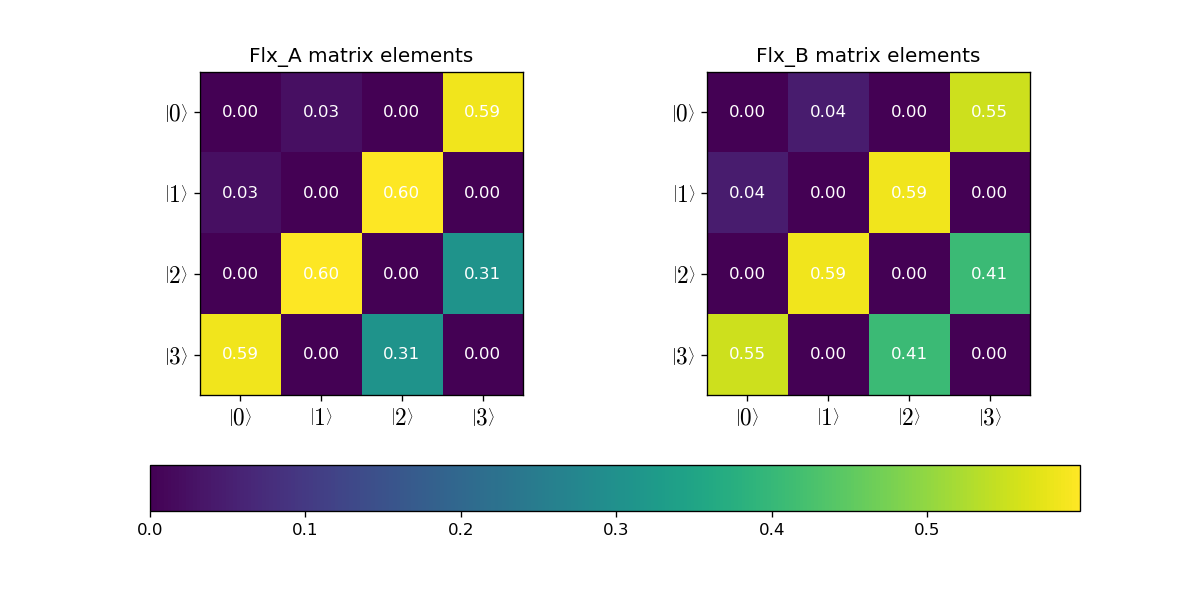

In [248]:
def plot_charge_op(flx, name, ax, vmin, vmax):
    lv = range(levels)
    level_labels = [r'$\left|{}\right\rangle$'.format(level) for level in lv]
    mat_elements = flx.mat_elements(operator='charge_op', levels=lv, as_xarray=True)

    
    im = ax.imshow(np.abs(mat_elements), cmap='viridis', vmin = vmin, vmax = vmax)

    for in_level, out_level in product(lv, repeat=2):
        amplitude = abs(mat_elements.sel(in_level=in_level, out_level=out_level))
        ax.text(in_level, out_level, '{:.2f}'.format(float(amplitude)), ha="center", va="center", color="white")

    ax.set_xticks(lv)
    ax.set_yticks(lv)
    ax.set_xticklabels(level_labels, fontsize = 14)
    ax.set_yticklabels(level_labels, fontsize = 14)

#     cbar = plt.colorbar()
#     cbar.ax.set_ylabel(r"Amplitude $\hat{n}^{F}_{i \rightarrow f}$", rotation=-90, va="bottom")

    ax.set_title(name +  ' matrix elements')

    return im

vmin = min(np.min(np.abs(flx_a.mat_elements(operator='charge_op', levels=range(4)))),
           np.min(np.abs(flx_b.mat_elements(operator='charge_op', levels=range(4)))))

vmax = max(np.max(np.abs(flx_a.mat_elements(operator='charge_op', levels=range(4)))),
           np.max(np.abs(flx_b.mat_elements(operator='charge_op', levels=range(4)))))

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ima = plot_charge_op(flx_a, "Flx_A", ax[0], vmin, vmax)
imb = plot_charge_op(flx_b, "Flx_B", ax[1], vmin, vmax)

fig.colorbar(ima, ax=ax.ravel().tolist(), orientation = 'horizontal')

In [78]:
energies_ab_bare = np.zeros(levels**2, dtype=float)
count = 0
for k in range(0, levels):
    for m in range(0, levels):
        energies_ab_bare[count] = energies_b[m] + energies_a[k]
        count += 1
label_converter = np.argsort(energies_ab_bare)

In [79]:
# This function allows to return the energy of the "adiabatically continued" coupled levels
def label_to_energies(
    k: int, 
    m: int,
    levels: int,
    energies: np.ndarray,
    label_converter: np.ndarray
) -> float:
    label = k*levels + m
    index = np.where(label_converter==label)[0][0]
    return energies[index]

def label_to_states(
    k: int, 
    m: int,
    levels: int,
    eig_states: np.ndarray,
    label_converter: np.ndarray
) -> float:
    label = k*levels + m
    index = np.where(label_converter==label)[0][0]
    return eig_states[index] 

# Coupled fluxonia

As a preliminary study, I want to plot the energy levels of the coupled system as a function of the coupling strength $J_C$. I take coupling strengths similar to those taken in the paper (see Fig. 2).

In [85]:
text_lab = ["$| 00 \\rangle $", "$| 01 \\rangle $", "$| 10 \\rangle $", "$| 11 \\rangle $", \
            "$| 02 \\rangle $", "$| 12 \\rangle $", "$| 20 \\rangle $", "$| 21 \\rangle $"]

text_lab_no_latex = ["|00>", "|01>", "|10>", "|11>", \
                     "|02>", "|12>", "|20>", "|21>" ]

## Role of J_c

In [82]:
n_points = 20
levels_plot = 8
jc_list = np.linspace(0, 0.4, n_points)
en_mat = np.zeros([levels_plot, n_points], dtype=float)
for k in range(0, n_points):
    coupled_flx = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc_list[k])
    en_mat[:, k] = coupled_flx.eig_energies(levels_plot)

<IPython.core.display.Javascript object>


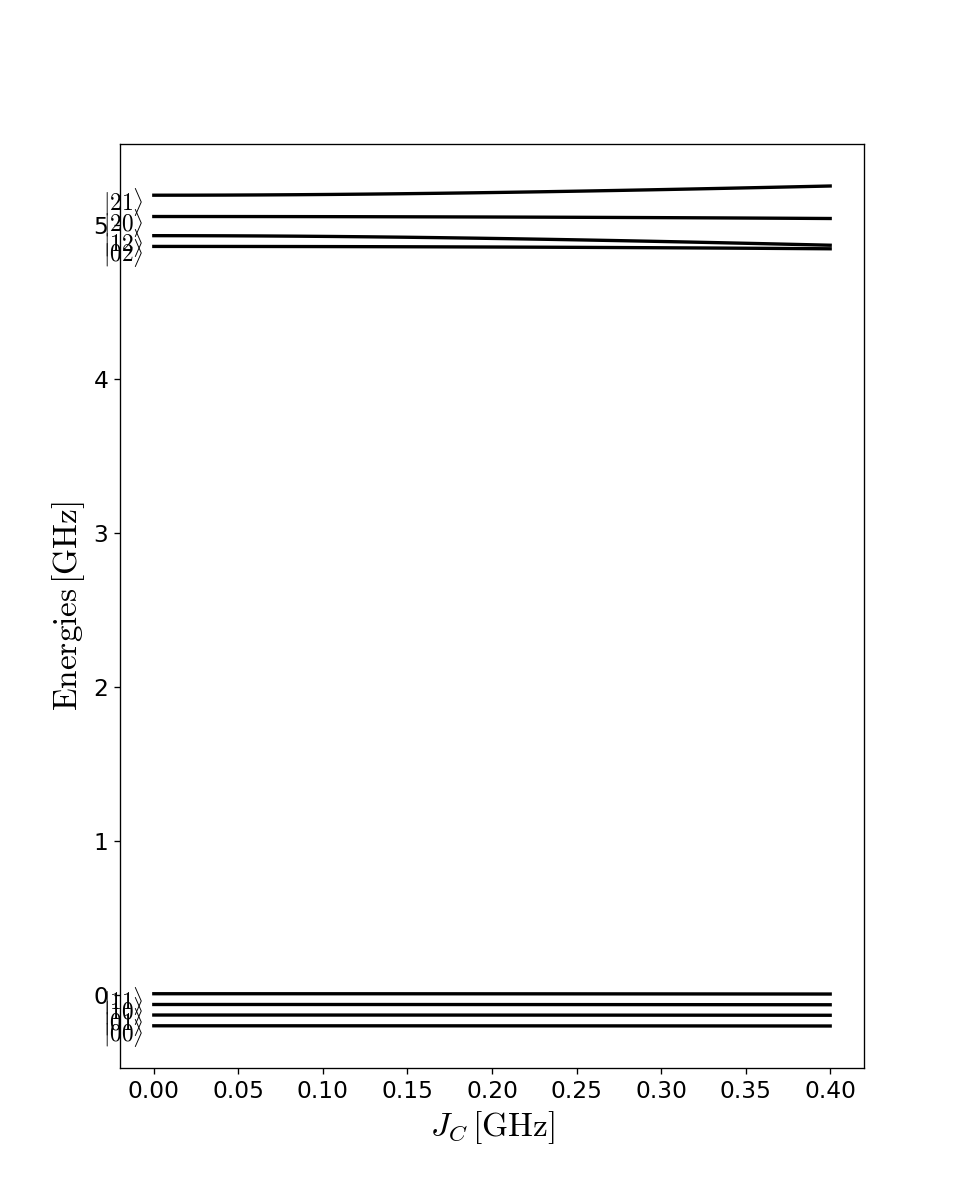

In [254]:
plot_setup = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}

def plot_energies_jc(
    en_mat: np.ndarray, 
    jc_list:np.ndarray, 
    opt:dict
) -> None:
    n_lev = en_mat.shape[0]
    text_lab = ["$| 00 \\rangle $", "$| 01 \\rangle $", "$| 10 \\rangle $", "$| 11 \\rangle $", \
                "$| 02 \\rangle $", "$| 12 \\rangle $", "$| 20 \\rangle $", "$| 21 \\rangle $"]
    fig, ax = plt.subplots(figsize=(8, 10))
    for k in range(0, n_lev):
        ax.plot(jc_list, en_mat[k, :], linewidth=opt['lw'], color='black')
        plt.text(-0.03, en_mat[k, 0] - 0.1, text_lab[k], fontsize=opt['fs_text'], color='black')
    ax.axes.set_xlabel("$J_C \, \mathrm{[GHz]}$", fontsize=opt['fs'])
    ax.axes.set_ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
#     ax.set_xlim([np.min(jc_list) - 0.04, np.max(jc_list)])
#     ax.set_ylim([en_mat[0, 0] - 0.5, en_mat[n_lev - 1, 0] + 0.5])
    ax.tick_params(axis='both', labelsize=opt['ls'])
    plt.show()
    
plot_energies_jc(en_mat, jc_list, plot_setup)    

## Energies and eigenvalues of H

In [89]:
jc = 0.224 #GHz (divided by h)

coupled_flx = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_sys, eigstates_sys = coupled_flx.eig_states() 

coupled_flx_bare = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
energies_bare, eigstates_bare = coupled_flx_bare.eig_states() 

big_delta = energies_sys[7] - energies_sys[6] + energies_sys[1] - energies_sys[3]
small_delta_opt = .29*big_delta

freq_drive_opt = energies_sys[7] - energies_sys[3] - small_delta_opt
freq_drive = freq_drive_opt

t_drive = 1/big_delta

for k in range(len(text_lab)):
    print(str(k)+"th energy level " + text_lab_no_latex[k] + " :  Bare : " + str(np.round(energies_bare[k], 4)) + 
          "[GHz] || Interacting : " + str(np.round(energies_sys[k], 4)) + "[GHz]")

0th energy level |00> :  Bare : -0.2006[GHz] || Interacting : -0.201[GHz]
1th energy level |01> :  Bare : -0.1307[GHz] || Interacting : -0.1312[GHz]
2th energy level |10> :  Bare : -0.0622[GHz] || Interacting : -0.0628[GHz]
3th energy level |11> :  Bare : 0.0076[GHz] || Interacting : 0.007[GHz]
4th energy level |02> :  Bare : 4.8602[GHz] || Interacting : 4.8553[GHz]
5th energy level |12> :  Bare : 4.93[GHz] || Interacting : 4.9079[GHz]
6th energy level |20> :  Bare : 5.0544[GHz] || Interacting : 5.0503[GHz]
7th energy level |21> :  Bare : 5.1927[GHz] || Interacting : 5.2141[GHz]


<IPython.core.display.Javascript object>


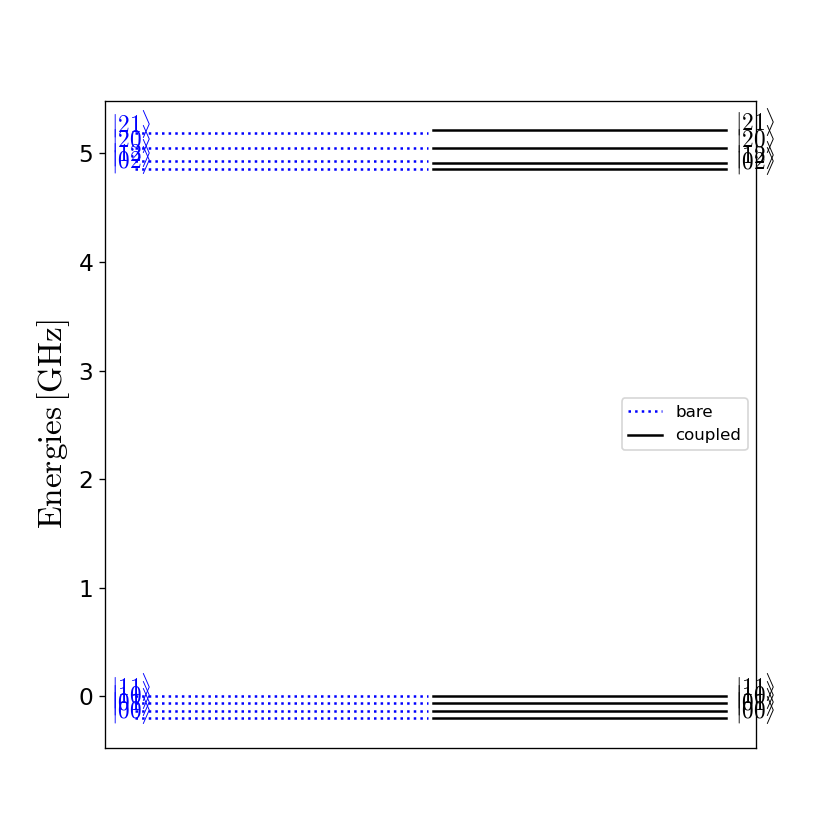

In [260]:
#Compare levels bare-int

opt = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}
text_lab = ["$| 00 \\rangle $", "$| 01 \\rangle $", "$| 10 \\rangle $", "$| 11 \\rangle $", \
            "$| 02 \\rangle $", "$| 12 \\rangle $", "$| 20 \\rangle $", "$| 21 \\rangle $"]

plt.figure(figsize=(7, 7))
for k in range(0, 8):
    plt.plot([0,.99], [energies_bare[k]]*2, color='blue', linestyle = ':', label = "bare")
    plt.text(-0.08, energies_bare[k], text_lab[k], fontsize=opt['fs_text'], color='blue')
    
    plt.plot([1.01, 2], [energies_sys[k]]*2, color='black', label = "coupled")
    plt.text(+2.03, energies_sys[k], text_lab[k], fontsize=opt['fs_text'], color='black')
    
    if k==0:
        plt.legend()
    
plt.ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
plt.tick_params(axis='both', labelsize=opt['ls'])

frame1 = plt.gca()
frame1.axes.xaxis.set_visible(False)



<IPython.core.display.Javascript object>


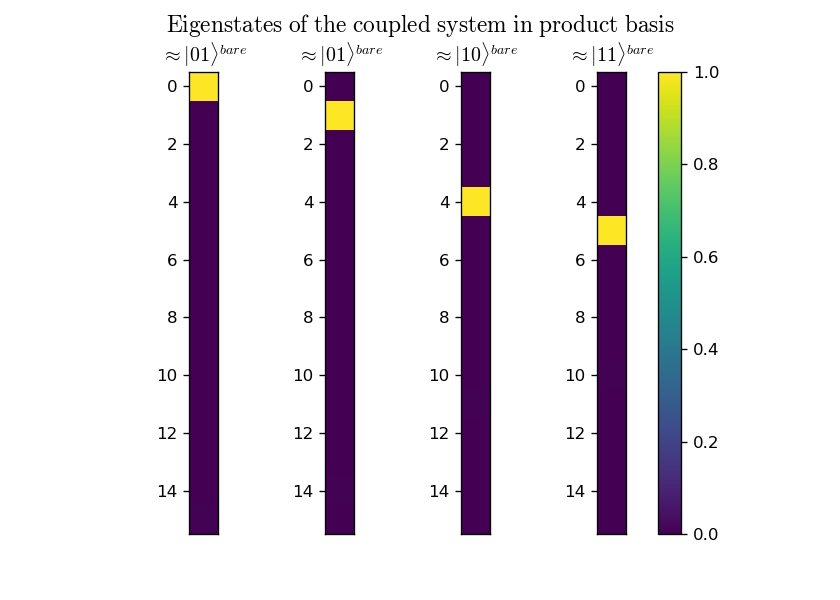

Text(0.5, 0.98, '$\\mathrm{Eigenstates \\ of \\ the \\ coupled \\ system \\ in \\ product \\ basis}$')

In [256]:
state00 = qtp.Qobj(inpt=  label_to_states(0, 0, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state01 = qtp.Qobj(inpt=  label_to_states(0, 1, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state10 = qtp.Qobj(inpt=  label_to_states(1, 0, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state11 = qtp.Qobj(inpt=  label_to_states(1, 1, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])

fig, ax = plt.subplots(1, 4, figsize = (7,5))

im0 = ax[0].imshow(np.abs(state00.full()), vmin = 0, vmax = 1)
ax[0].axes.xaxis.set_visible(False)
ax[0].set_title("$\\approx | 01 \\rangle ^{bare}$")

ax[1].imshow(np.abs(state01.full()), vmin = 0, vmax = 1)
ax[1].axes.xaxis.set_visible(False)
ax[1].set_title('$\\approx | 01 \\rangle ^{bare}$')

ax[2].imshow(np.abs(state10.full()), vmin = 0, vmax = 1)
ax[2].axes.xaxis.set_visible(False)
ax[2].set_title('$\\approx | 10 \\rangle ^{bare}$')

ax[3].imshow(np.abs(state11.full()), vmin = 0, vmax = 1)
ax[3].axes.xaxis.set_visible(False)
ax[3].set_title('$\\approx | 11 \\rangle ^{bare}$')

fig.colorbar(im0, ax=ax[:].ravel().tolist(), orientation = 'vertical')

fig = plt.gcf()
fig.suptitle('$\mathrm{Eigenstates \ of \ the \ coupled \ system \ in \ product \ basis}$', fontsize=14)

<IPython.core.display.Javascript object>


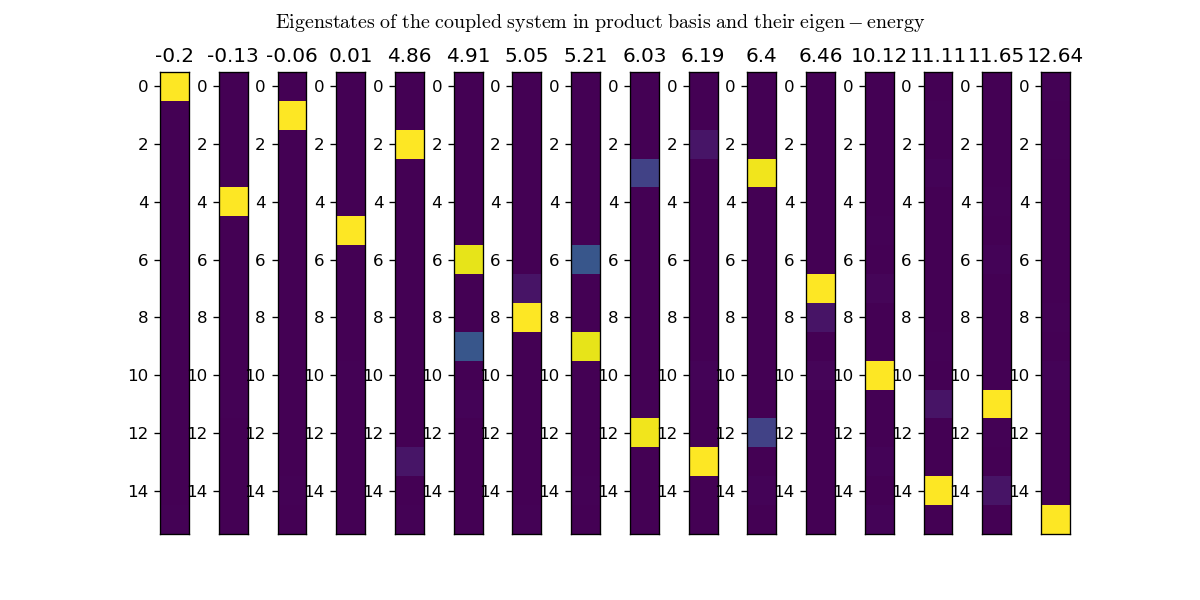

Text(0.5, 0.98, '$\\mathrm{Eigenstates \\ of \\ the \\ coupled \\ system \\ in \\ product               \\ basis \\ and \\ their \\ eigen-energy}$')

In [257]:
fig, ax = plt.subplots(1, 16, figsize = (10,5))
for k in range(levels**2):
    ax[k].imshow(np.abs(np.array([eigstates_sys[k]]).T), vmin = 0, vmax = 1)
    ax[k].axes.xaxis.set_visible(False)
    ax[k].set_title(np.round(energies_sys[k], 2))
    
fig = plt.gcf()
fig.suptitle('$\mathrm{Eigenstates \ of \ the \ coupled \ system \ in \ product  \
             \ basis \ and \ their \ eigen-energy}$', fontsize=12)

# Drive

In [168]:
print('Optimal drive frequency fd: ' + str(freq_drive) + ' [GHz]')

Optimal drive frequency fd: 5.199663485390033 [GHz]


We use the conventions of the paper :
$$\Delta = f_{11-21} - f_{10-20}$$
$$\delta = f_{11-21} - f_d$$

According to the paper, the optimal value for $\dfrac{\delta}{\Delta}$ is $\dfrac{\delta}{\Delta} = 0.29 $

With this $\delta$, we have $\Omega = \Delta$ and a CZ gate is achieved with zero leakage in time exactly $t_{drive} = 1/\Delta$

In [169]:
eta = [.5, .5]
n_a = tensor_prod([flx_a.charge_op(), np.identity(levels)])
n_b = tensor_prod([np.identity(levels), flx_b.charge_op()])
n_charge = [n_a, n_b]



In [170]:
rabi_freq = big_delta

rabi_period = 1/rabi_freq # [ns]
print('Rabi period: ' + str(rabi_period) + ' [ns]')

Rabi period: 39.0376874795923 [ns]


#  Simulations

We now want to perform simulations. The first task is to reproduce the two-photon Rabi oscillations and show that they reproduce correctly the Rabi period.

In [171]:
#simulation setup (noiseless)
t_points = 10000
tlist = np.linspace(0, 2*rabi_period*2*np.pi, t_points)

# state_in = qtp.Qobj(inpt=  sum(eigstates_sys[:4]), dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state_in = state00 + state01 + state10 + state11
rho_in = state_in*state_in.dag()

hamil0 = coupled_flx.hamiltonian(as_qobj=True)
hamil_drive = qtp.Qobj(inpt=eta[0]*n_charge[0] + eta[1]*n_charge[1], 
                       dims=hamil0.dims, shape=hamil0.shape, isherm=True)
pulse_drive = np.cos(freq_drive*tlist)

In [172]:
# Simulation run
result = solvkit.integrate(tlist, state_in, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")

## Probs

In [174]:
#Def the other states
state02 = qtp.Qobj(inpt=  label_to_states(0, 2, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state12 = qtp.Qobj(inpt=  label_to_states(1, 2, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state20 = qtp.Qobj(inpt=  label_to_states(2, 0, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state21 = qtp.Qobj(inpt=  label_to_states(2, 1, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])

#and the rhos
rho_00 = state00*state00.dag()
rho_01 = state01*state01.dag()
rho_10 = state10*state10.dag()
rho_11 = state11*state11.dag()

rho_02 = state02*state02.dag()
rho_12 = state12*state12.dag()
rho_20 = state20*state20.dag()
rho_21 = state21*state21.dag()

probs = np.zeros([8, t_points], dtype=float)
for k in range(0, t_points):
    probs[0, k] = qtp.expect(rho_00, result.states[k]) 
    probs[1, k] = qtp.expect(rho_01, result.states[k]) 
    probs[2, k] = qtp.expect(rho_10, result.states[k]) 
    probs[3, k] = qtp.expect(rho_11, result.states[k]) 
    probs[4, k] = qtp.expect(rho_02, result.states[k])
    probs[5, k] = qtp.expect(rho_12, result.states[k])
    probs[6, k] = qtp.expect(rho_20, result.states[k])
    probs[7, k] = qtp.expect(rho_21, result.states[k])

<IPython.core.display.Javascript object>


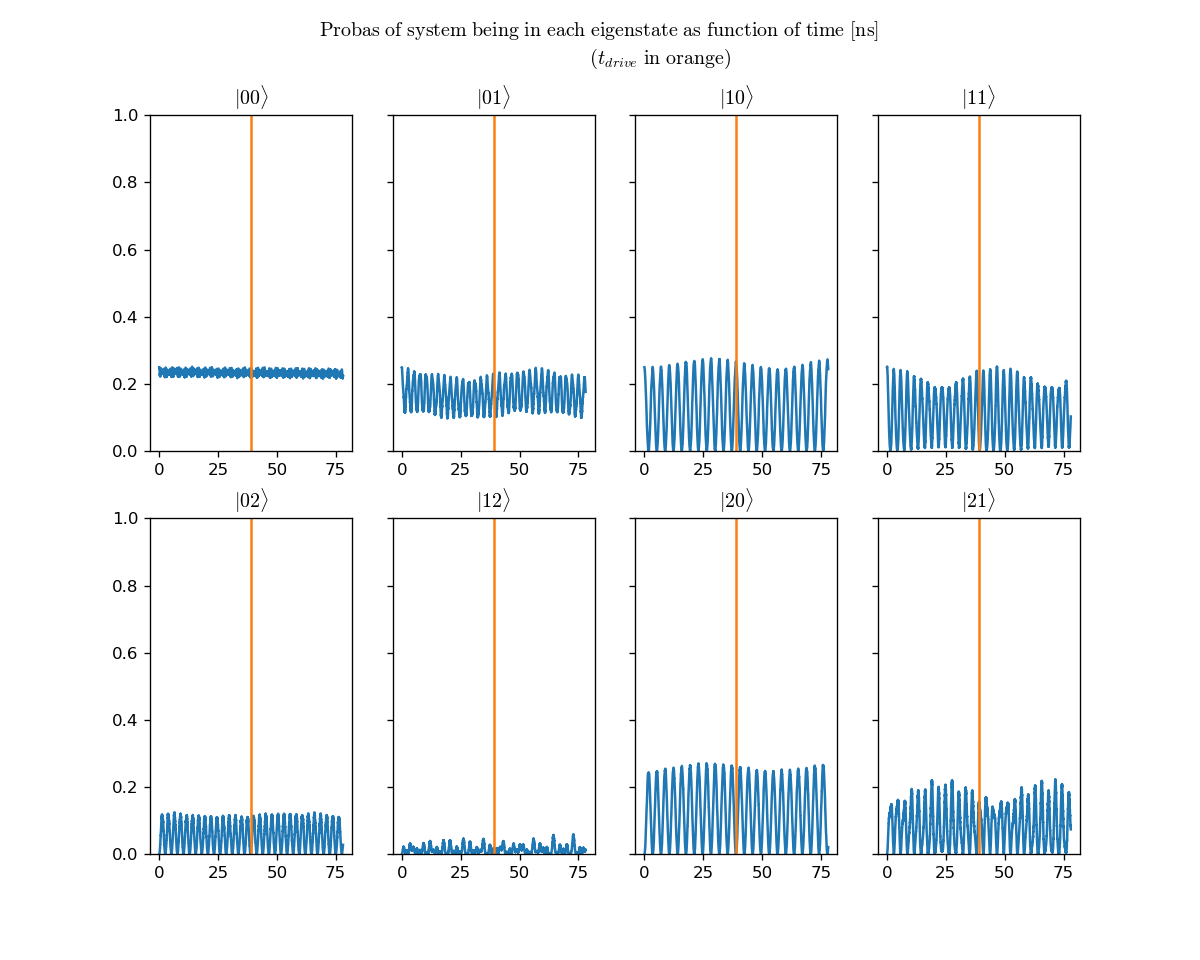

In [216]:
def plot_probas(
    tlist: np.ndarray, 
    probs: np.ndarray, 
    opt: dict
) -> None:
    cols = ['red', 'green', 'orange', 'blue']
    fig, ax = plt.subplots(2, 4, figsize = (10, 8))
    for k in range(0, 8):

        ax[k//levels, k%levels].plot(tlist, probs[k, :])
        ax[k//levels, k%levels].plot([t_drive, t_drive], [0, 1])

        ax[k//levels, k%levels].set_ylim(0, 1.0)
        ax[k//levels, k%levels].set_title(text_lab[k])
        
        if k%levels != 0:
            ax[k//levels, k%levels].axes.yaxis.set_ticklabels([])

        
    fig = plt.gcf()
    fig.suptitle('$\mathrm{Probas \ of \ system \ being \ in  \ \
                 each \ eigenstate \ as \ function \ of \ time \ [ns]}$ \n  \
                 $( t_{drive} \mathrm{ \ in \ orange})$', fontsize=12)
    
        
plot_probas(tlist/(2*np.pi), probs, plot_setup)
    

## Phases

In [ ]:
#phases : 

phases = np.zeros([4, t_points], dtype=float)
for k in range(0, t_points):
    phases[0, k] = cmath.phase((result.states[k].dag() * state00).full()[0,0])
    phases[1, k] = cmath.phase((result.states[k].dag() * state01).full()[0,0]) 
    phases[2, k] = cmath.phase((result.states[k].dag() * state10).full()[0,0])
    phases[3, k] = cmath.phase((result.states[k].dag() * state11).full()[0,0]) 

In [ ]:
plt.figure(figsize = (12, 7))
plt.plot(tlist/(2*np.pi), (phases[3,:]-phases[0,:]) - (phases[2,:]-phases[0,:]) - (phases[1,:]-phases[0,:]) )

In [ ]:
# Plot phases :
labels = ["00", "01", "10", "11"]
def plot_phases(
    tlist: np.ndarray, 
    probs: np.ndarray, 
    opt: dict
) -> None:
    cols = ['red', 'green', 'orange', 'blue']
    for k in range(0, 4):
        plt.figure(figsize = (12, 5))
        plt.plot(tlist, phases[k, :], label = labels[k])#, linewidth=opt['lw'], color=cols[k])
        plt.xlabel('$t \, [\mathrm{ns}]$', fontsize=opt['fs'])
        plt.ylabel('$P$', fontsize=opt['fs'])
        plt.tick_params(axis='both', labelsize=opt['ls'])
#         plt.ylim(0, 1.0)
        plt.legend()
        plt.show()

plot_phases(tlist/(2*np.pi), phases, plot_setup)

## Phases new

In [ ]:
phases = np.zeros((4, len(tlist)))

result = solvkit.integrate(tlist, state00, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")
phases[0, :] = [cmath.phase((result.states[k].dag() * state00).full()[0,0]) for k in range(len(tlist))]

result = solvkit.integrate(tlist, state01, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")
phases[1, :] = [cmath.phase((result.states[k].dag() * state01).full()[0,0]) for k in range(len(tlist))]

result = solvkit.integrate(tlist, state10, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")
phases[2, :] = [cmath.phase((result.states[k].dag() * state10).full()[0,0]) for k in range(len(tlist))]

result = solvkit.integrate(tlist, state11, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")
phases[3, :] = [cmath.phase((result.states[k].dag() * state11).full()[0,0]) for k in range(len(tlist))]

## Leakage

<IPython.core.display.Javascript object>


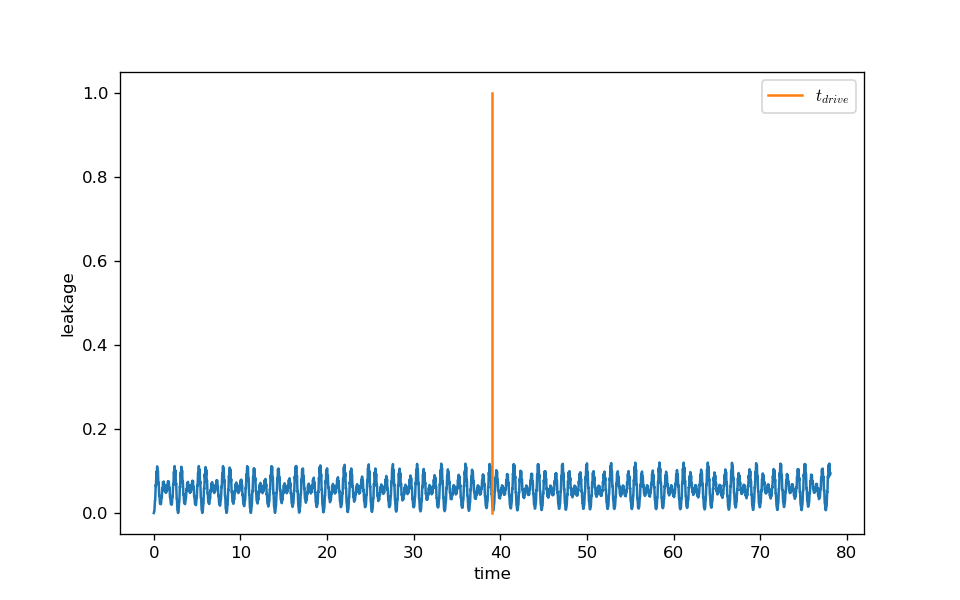

Max leakage over this time period is : 12.016236223388177%


In [188]:
def leakage(state_init, 
            tlist=tlist, hamil0=hamil0, hamil_drive=hamil_drive, pulse_drive=pulse_drive, 
            bool_plot = True):
    result = solvkit.integrate(tlist, state_init, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")
    
    probs = np.zeros([4, t_points], dtype=float)
    for k in range(0, t_points):
        probs[0, k] = qtp.expect(rho_00, result.states[k]) 
        probs[1, k] = qtp.expect(rho_01, result.states[k]) 
        probs[2, k] = qtp.expect(rho_10, result.states[k]) 
        probs[3, k] = qtp.expect(rho_11, result.states[k]) 
    
    leakage = [1-sum(probs[:,j]) for j in range(len(tlist))]
    if bool_plot:
        plt.figure()
        plt.plot(tlist/(2*np.pi), leakage)
        plt.plot([t_drive, t_drive], [0, 1], label = "$t_{drive}$")
        plt.xlabel('time')
        plt.ylabel('leakage')
        plt.legend()
        
    
    print("Max leakage over this time period is : "+ str(np.max(leakage)*100) + "%")
    
state_init = state00#state00 + state_01 + state_10 + state_11
leakage(state_init)

In [187]:
print("\nFor only state00:")
leakage(state00, bool_plot = False)

print("\nFor only state01:")
leakage(state01, bool_plot = False)

print("\nFor only state10:")
leakage(state10, bool_plot = False)

print("\nFor only state11:")
leakage(state11, bool_plot = False)


For only state00:
Max leakage over this time period is : 12.016236223388177%

For only state01:
Max leakage over this time period is : 54.836187742319765%

For only state10:
Max leakage over this time period is : 99.83970544949811%

For only state11:
Max leakage over this time period is : 99.39169018729773%


# Tomography

In [ ]:
def gate_function(state_in, **kwargs):
    t_points = kwargs['t_points']
    tlist = np.linspace(0, kwargs['t_max'], t_points)
    rho_in = state_in*state_in.dag()
    hamil0 = kwargs['hamil0']
    hamil_drive = kwargs['hamil_drive']
                                  
    pulse_drive = np.cos(kwargs['freq_drive']*tlist)

    result = solvkit.integrate(tlist, state_in, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")

    end_state = result.states[-1]
    return end_state

In [ ]:
param_dict = {
    't_points' : 10000 ,
    't_max' : t_drive,
    'hamil0' : coupled_flx.hamiltonian(as_qobj=True),
    'hamil_drive' : qtp.Qobj(inpt=eta[0]*n_charge[0] + eta[1]*n_charge[1], 
                       dims=hamil0.dims, shape=hamil0.shape, isherm=True),
    'freq_drive' : freq_drive
}

In [ ]:
import pysqkit.tomography.utilsTomo as tomo

In [ ]:
fct = tomo.rid_of_dict(gate_function,param_dict)
nb_levels = [3,3]

In [ ]:
deb =  time.time()
lambda_mat = tomo.fct_to_lambda(fct, nb_levels, draw_lambda = True)
print("It took" , time.time() - deb, "seconds")

In [ ]:
deb =  time.time()
chi_mat = tomo.lambda_to_chi(lambda_mat, nb_levels, draw_chi = True )
print("It took" , time.time() - deb, "seconds")

In [ ]:
lambda_mat_2lev = np.zeros((16, 16))*1j

for i in range(16):
    for j in range(16):
        ani, bni, ami, bmi = tomo._n_th([2, 2, 2, 2], i) #i is |ani bni><ami bmi|
        anj, bnj, amj, bmj = tomo._n_th([2, 2, 2, 2], j)
        
        lambda_mat_2lev[i,j] = lambda_mat[ani*27 + bni * 9 + ami * 3 + bmi][anj*27 + bnj * 9 + amj* 3 + bmj]

In [ ]:
tomo.draw_mat(lambda_mat_2lev, "\lambda^2")

In [ ]:
chi_mat_2lev = tomo.lambda_to_chi(lambda_mat_2lev, [2,2], draw_chi = True)

chi_CZ = np.zeros((16,16))
chi_CZ[0,0] = 1
chi_CZ[0,3] = 1
chi_CZ[3,0] = 1
chi_CZ[3,3] = 1

chi_CZ[0,12] = 1
chi_CZ[3,12] = 1
chi_CZ[0,15] = -1
chi_CZ[3,15] = -1

chi_CZ[12,12] = 1
chi_CZ[15,12] = -1
chi_CZ[12,15] = -1
chi_CZ[15,15] = 1

chi_CZ[12,0] = 1
chi_CZ[12,3] = 1
chi_CZ[15,0] = -1
chi_CZ[15,3] = -1

tomo.draw_mat(chi_CZ, "\chi^{CZ}")